an _attempted_ implementation of variational Sequential Monte Carlo for state space models.

Goals:
1. demonstrate that the estimated $\log \hat{\frac{Z_1}{Z_0}}$ approaches the true $\log \frac{Z_1}{Z_0}$ from below and identify a static model (in the ULA propagation regime) where there is room for improvement.
2. demonstrate that the ELBO can be increased via training.

# SIS demonstration
I will pick up from my previous [notebook](https://colab.research.google.com/gist/dominicrufa/e167aba420b0588bafb45e2a9092598e/melange_smc_vanilla.ipynb) and demonstrate SIS on a static model that is difficult to generate good log posterior estimates. I will show that estimates can be improved with more intermediate 'bridging' distributions that interpolate linearly from $\pi_0$ to $\pi_1$

## Utilities
The first SIS I will conduct is identical to the aforementioned notebook's `Annealing Time Experiment`.

In [1]:
from jax import vmap, grad
from jax.lax import scan
from melange.miscellaneous import compute_log_pdf_ratio
from melange.propagators import Euler_Maruyama_log_proposal_ratio, forward_ULA_sampler, log_Euler_Maruyma_kernel
from melange.miscellaneous import calculate_SIS_nESS, calculate_SIS_log_partition_ratio
import numpy as np
from melange.tests.utils import get_default_potential_initializer
from jax import random
import jax.numpy as jnp

In [2]:
#define the potential
def potential(pos, parameter): #potential will anneal from mean of 0 to 3 (from parameter=0 to 1)
    mod_parameter = parameter[0]
    x0 = jnp.ones(pos.shape)*3 # at lambda=1, the mean is 3.
    return (1. - mod_parameter)*jnp.dot(pos, pos) + mod_parameter*jnp.dot(pos - x0, pos - x0)

#define a forward (auxiliary) potential
def v1_forward_potential(pos, parameter):
    assert len(parameter) == 3
    mod_parameter,aux_mean, aux_scale = parameter
    x0 = jnp.ones(pos.shape)*3 # at lambda=1, the mean is 3.
    base_potential = (1. - mod_parameter)*jnp.dot(pos, pos) + mod_parameter*jnp.dot(pos - x0, pos - x0)
    bias_potential = aux_scale*jnp.dot(pos - jnp.array([aux_mean]), pos - jnp.array([aux_mean]))
    return base_potential + bias_potential

#vectorize the calculators
vcompute_log_pdf_ratio = vmap(compute_log_pdf_ratio, in_axes=(None, None, None, 0,0))
vlog_proposal_ratio = vmap(Euler_Maruyama_log_proposal_ratio, in_axes=(0,0,None, None, None, None, None, None))
batched_potential = vmap(potential, in_axes=(0,None))

def ULA_SIS_log_weights_calculator(trajectories, forward_kernel_parameters, backward_kernel_parameters, potential_parameters, potential, dt):
    assert len(backward_kernel_parameters) == len(forward_kernel_parameters) - 1 # the sequence of backward_kernel_parameters is 1 less than the sequence of forward_kernel_parameters
    assert len(forward_kernel_parameters) == len(potential_parameters)

    def weight_scan_function(carrier, t): #define a scan function to iterate over full trajectories
        xs_tm1, xs_t = trajectories[t-1], trajectories[t] #define batched positions
        log_pdf_ratios = vcompute_log_pdf_ratio(potential, potential_parameters[t-1], potential_parameters[t], xs_tm1, xs_t) #compute potential differences
        log_kernel_ratios = vlog_proposal_ratio(xs_tm1, xs_t, potential, forward_kernel_parameters[t], dt, potential, backward_kernel_parameters[t-1], dt) #compute log proposal ratios
        return None, log_pdf_ratios + log_kernel_ratios
  
    start_log_weights = batched_potential(trajectories[0], forward_kernel_parameters[0]) - batched_potential(trajectories[0], potential_parameters[0])
    # ^if the K_0 corresponds to \pi_0, then these log weights are _all_ 0
    _, log_weight_matrix = scan(weight_scan_function, None, jnp.arange(1,len(forward_kernel_parameters)))

    return jnp.vstack((start_log_weights, log_weight_matrix)) #return the unnormalized stacked log weight matrix

def ULA_SIS(key, #starting randomization key 
            num_particles, #number of particles
            dt, #time increment
            starting_mu, #K_0 mu
            starting_cov, #K_0 covariance
            forward_kernel_parameters, #sequence of forward kernel parameters K
            backward_kernel_parameters,  #sequence of backward kernel parameters L
            potential_parameters, # parameters of the potential
            potential): #potential function
    key, genkey = random.split(key)

    #generate i.i.d. samples from \pi_0
    x_ula_starter = random.multivariate_normal(key = genkey, mean = starting_mu, cov = starting_cov, shape=[num_particles])

    #anneal all of the particles without resampling
    trajectories = forward_ULA_sampler(x_ula_starter, potential, dt, key, forward_kernel_parameters[1:])
    all_trajectories = jnp.vstack((x_ula_starter[jnp.newaxis, ...], trajectories))

    #compute the weights
    weight_matrix = ULA_SIS_log_weights_calculator(trajectories, forward_kernel_parameters, backward_kernel_parameters, potential_parameters, potential, dt)

    return all_trajectories, weight_matrix

In [3]:
def bootstrap_subsample_log_partition_ratio(log_weight_matrix, num_bootstraps):
    """
    bootstrap subsample the weights
    """
    from scipy import stats
    from jax.scipy.special import logsumexp
    subsample_size = log_weight_matrix.shape[1]
    full_accumulated_weights = log_weight_matrix.sum(0)
    log_Z_ratios = []
    for i in range(num_bootstraps):
        subsamples = np.random.choice(full_accumulated_weights, size=subsample_size)
        log_Z_ratios.append(logsumexp(subsamples) - jnp.log(subsample_size))
    return np.array(log_Z_ratios)

## Annealing Time Experiments


In [4]:
key = random.PRNGKey(1001)
dimension=1
_, (mu, cov), dG = get_default_potential_initializer(dimension)
dt=1e-2
num_particles=1000
num_bootstraps = 500
sequence_lengths=[10, 50, 100, 500,1000, 5000]

logZs = []
nESSs = []

for sequence_length in sequence_lengths:
    key, runkey = random.split(key)
    potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis]
    forward_kernel_parameters = potential_parameters
    backward_kernel_parameters = potential_parameters[1:]
    trajs, log_weight_matrix = ULA_SIS(runkey, num_particles, dt, mu, cov, forward_kernel_parameters, backward_kernel_parameters, potential_parameters, potential)
    logZ_parts = bootstrap_subsample_log_partition_ratio(log_weight_matrix, num_bootstraps)
    nESS = calculate_SIS_nESS(log_weight_matrix)
    logZs.append(logZ_parts)
    nESSs.append(nESS)

/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
# do statistics on the logZs
logZs = np.array(logZs)
print(logZs.shape)
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h
logZ_statistics = np.array([mean_confidence_interval(i) for i in logZs])

(6, 500)


I'll plot the bootstrapped histograms of the log partition ratio.

Text(0.5, 0, 'log partition ratio')

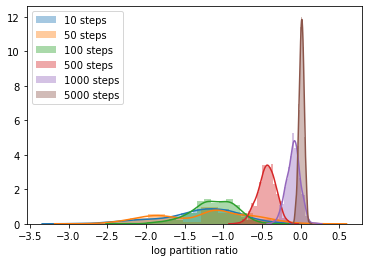

In [7]:
for steps, entry in zip(sequence_lengths, logZs):
    sns.distplot(entry, label = f"{steps} steps")
plt.legend()
plt.xlabel(f"log partition ratio")

and the mean bootstrapped log partition ratio with the length of the SIS sequence.

Text(0, 0.5, '<log(Z_1/Z_0)>')

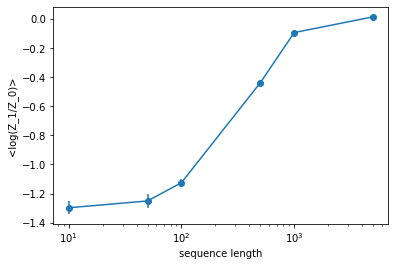

In [8]:
plt.errorbar(sequence_lengths, logZ_statistics[:,0], yerr = logZ_statistics[:,1], ls=None, marker='o')
plt.xscale('log')
plt.xlabel(f"sequence length")
plt.ylabel(f"<log(Z_1/Z_0)>")

and for good measure, the normalized effective sample size with the sequence length.

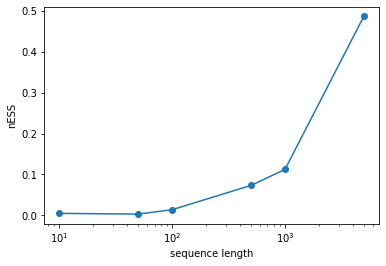

In [9]:
plt.plot(sequence_lengths, nESSs, marker='o')
plt.xlabel('sequence length')
plt.ylabel(f"nESS")
plt.xscale('log')

lastly, I'll plot the accumulated weights w.r.t. the sequence (for the longest sequence)

Text(0, 0.5, 'cumulative log weight')

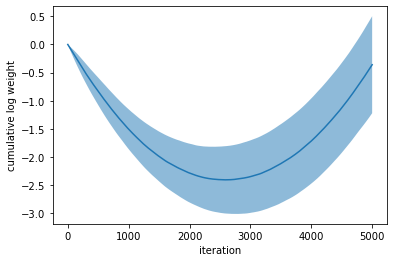

In [10]:
cum_log_weights = jnp.cumsum(log_weight_matrix, 0)
cum_log_weight_mean = cum_log_weights.mean(1)
cum_log_weight_var = cum_log_weights.std(1)
plt.fill_between(jnp.arange(5000), cum_log_weight_mean + cum_log_weight_var, cum_log_weight_mean - cum_log_weight_var, alpha=0.5)
plt.plot(jnp.arange(5000), cum_log_weight_mean)
plt.xlabel(f"iteration")
plt.ylabel(f"cumulative log weight")

# Variational Sequential Monte Carlo (vSMC)
Goals:
1. demonstrate that the log partition ratio estimator suffers when the forward kernels and backward kernels do not target the same invariant distribution (i.e. moving _away_ from the AIS regime).
2. update utilities to allow for the forward kernels to target differently-parameterized target distributions (and different variances).
3. attempt to maximize the ELBO by using variational optimization on the new forward kernel parameters.


## Away from AIS
Here, the sequence of backward kernels will remain unchanged, but the forward kernels will _not_ target the same sequence of invariant distributions. Specifically, while the backward kernels will linearly interpolate their invariant distribution parameters from 0. to 1., the forward kernels will go like a Relu function.

In [11]:
def Relu(x, activation=0.5):
    if x < activation:
        return 0.
    else:
        return x

In [12]:
key = random.PRNGKey(1001)
sequence_lengths=[10, 50, 100, 500,1000, 5000]


subopt_logZs = []
subopt_nESSs = []

for sequence_length in sequence_lengths:
    key, runkey = random.split(key)
    potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis]
    forward_kernel_parameters = jnp.array([Relu(i) for i in jnp.linspace(0,1,sequence_length)])[..., jnp.newaxis]
    backward_kernel_parameters = potential_parameters[1:]
    trajs, suboptlog_weight_matrix = ULA_SIS(runkey, num_particles, dt, mu, cov, forward_kernel_parameters, backward_kernel_parameters, potential_parameters, potential)
    suboptlogZ_parts = bootstrap_subsample_log_partition_ratio(suboptlog_weight_matrix, num_bootstraps)
    nESS = calculate_SIS_nESS(suboptlog_weight_matrix)
    subopt_logZs.append(suboptlogZ_parts)
    subopt_nESSs.append(nESS)



again, let's plot the bootstrapped distributions of log partition ratios for each sequence length

Text(0.5, 0, 'log partition ratio')

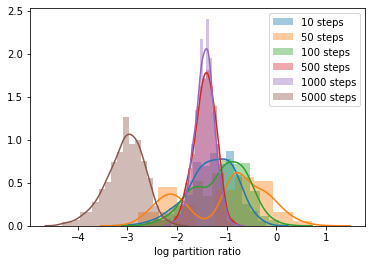

In [13]:
for steps, entry in zip(sequence_lengths, subopt_logZs):
    sns.distplot(entry, label = f"{steps} steps")
plt.legend()
plt.xlabel(f"log partition ratio")

and the bootstrapped mean log partition ratios

Text(0, 0.5, '<log(Z_1/Z_0)>')

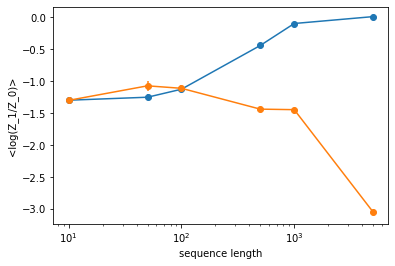

In [14]:
suboptlogZ_statistics = np.array([mean_confidence_interval(i) for i in subopt_logZs])
plt.errorbar(sequence_lengths, logZ_statistics[:,0], yerr = logZ_statistics[:,1], ls=None, marker='o')
plt.errorbar(sequence_lengths, suboptlogZ_statistics[:,0], yerr = suboptlogZ_statistics[:,1], ls=None, marker='o')
plt.xscale('log')
plt.xlabel(f"sequence length")
plt.ylabel(f"<log(Z_1/Z_0)>")

we can get an understanding of how poorly the "far-from-AIS" performs by comparing its nESS to that of the "close-to-AIS" nESS

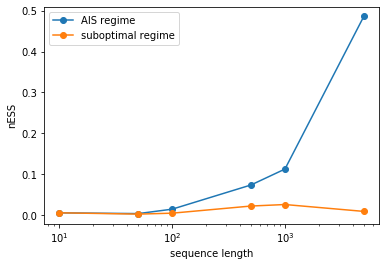

In [15]:
plt.plot(sequence_lengths, nESSs, marker='o', label = 'AIS regime')
plt.plot(sequence_lengths, subopt_nESSs, marker='o', label = f"suboptimal regime")
plt.xlabel('sequence length')
plt.ylabel(f"nESS")
plt.xscale('log')
plt.legend()

by looking at the normalized effective sample size, it's easy to tell that the suboptimal sequence of forward kernels really suffers compared to that in the AIS regime. For another comparison, we can look at the mean cumulative weights of the "near-AIS" and "far-from-AIS" experiments.

Text(0, 0.5, 'cumulative log weight')

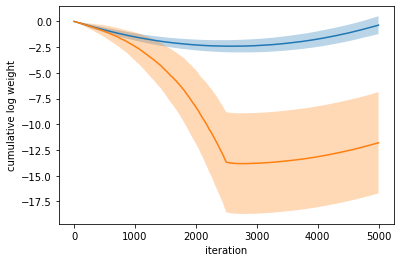

In [16]:
cum_suboptlog_weights = jnp.cumsum(suboptlog_weight_matrix, 0)
cum_suboptlog_weight_mean = cum_suboptlog_weights.mean(1)
cum_suboptlog_weight_var = cum_suboptlog_weights.std(1)
plt.fill_between(jnp.arange(5000), cum_log_weight_mean + cum_log_weight_var, cum_log_weight_mean - cum_log_weight_var, alpha=0.3)
plt.plot(jnp.arange(5000), cum_log_weight_mean)
plt.fill_between(jnp.arange(5000), cum_suboptlog_weight_mean + cum_suboptlog_weight_var, cum_suboptlog_weight_mean - cum_suboptlog_weight_var, alpha=0.3)
plt.plot(jnp.arange(5000), cum_suboptlog_weight_mean)
plt.xlabel(f"iteration")
plt.ylabel(f"cumulative log weight")

## VSMC utilities
In order to (attempt to) implement VSMC in the static model regime, I need to expand the current SIS features. In particular, I want to implement a model where the forward kernel can have a variable timestep (dt) and target an invariant potential that can be parameterized differently than the backward kernel potential function and target invariant. To do this, I need:
1. a vectorized propagator that takes a variable timestep (the potential is already manually equipped)
2. a `log_kernel_ratio` calculator that is able to perform calculations on forward and backward kernels that have different invariant distribution parameterizations.
3. a function that is able to take an unnormalized log weight matrix and take the gradient w.r.t. _only_ the "incremental" weight. 

let's solvent `1.` and `2.` with a `git pull` and re-installation...

i will try to avoid making in-place modifications to the `melange` codebase, but this is a work-in-progress (hopefully toward progress) and some modifications I will use recurrently, and so are worth the changes.

In [17]:
from melange.propagators import forward_ULA_sampler
from melange.vsmc import *

I'll write `3.` in the spirit of Christian Naesseth's [Elements of Sequential Monte Carlo](https://arxiv.org/pdf/1903.04797.pdf) (see Eqs. 53 through 58) since it is a more generalized interpretation of vSMC than the [paper](https://arxiv.org/pdf/1705.11140.pdf). 

### `compute_log_weights`
this is a modified `ULA_SIS_log_weights_calculator` that generated an unnormalized log weight matrix given a set of particle trajectories. it is a generalization of the previous function since it allows for the forward and backward kernels to target different distributions (which may be parameterized differently) and allows for sequence-dependent timesteps.

**Important**
On a related note, and in the interest of computing $\log \hat{\frac{Z_1}{Z_0}}$, we do _not_ want to variationally optimize the $\pi_0$ w.r.t. parameters $\mathbb{\lambda_0}$. Therefore, the initial log unnormalized weights will be computed w.r.t. the $\pi_0$ potential, not the invariant distribution associated with $K_0(\lambda_0)$. The only restriction in this regard is that the invariant of $K_0$ respects $\pi_0$

### compute log partition ratio.
I need a separate function to compute the log partition ratio from the above `compute_log_weights`

### compute $\hat{g}_{rep}$
In order to compute the approximate surrogate ELBO gradient, I have to be able to take the summation of the log weights and the gradient of _only_ the log _incremental_ weights.

In [18]:
def log_weights_summation_scanner(summation, log_unnormalized_weights):
    normalized_weights = jnp.exp(log_unnormalized_weights - logsumexp(log_unnormalized_weights))
    return summation + jnp.dot(stop_gradient(normalized_weights), log_unnormalized_weights), None

def log_weights_summation(weight_matrix_function, *args):
    log_weight_matrix = weight_matrix_function(*args)
    init=0.
    summation, neglect_out = scan(log_weights_summation_scanner, init, log_weight_matrix)
    return summation

def g_vsmc(weight_matrix_function, arg_tuple, arg_idx_to_diff):
    arg_idx_to_diff = tuple([i+1 for i in arg_idx_to_diff])
    grad_function = grad(log_weights_summation, arg_idx_to_diff)
    g_rep = grad_function(weight_matrix_function, *arg_tuple)
    return g_rep

### ULA SIS vSMC iteration
(that's a lot of acronyms. sorry)

make a function that will conduct one round of ULA SIS and return a log weight matrix, as well as $\hat{g}_{rep}$ thereof in order to take a gradient step.

In [19]:
def ULA_vSMC_iteration(num_particles,
                       potential,
                       potential_parameters,
                       forward_potential, 
                       forward_potential_parameters,
                       forward_dts,
                       backward_potential, 
                       backward_potential_parameters, 
                       backward_dts,
                       starter_key,
                       mu,
                       cov):
    """
    conduct an unadjusted langevin algorithm iteration of variational Sequential Monte Carlo

    arguments (do not repeat the previously-defined arguments):
        starter_key : random.PRNGKEY
            pseudorandom key
        mu : jnp.array(D)
            center of gaussian proposal (K_0 parameters)
        cov : jnp.array(D,D)
            covariance (variance in R^1) of the gaussian proposal (K_0 parameter)
    """
    init_key, runner_key = random.split(starter_key)
    xs = random.multivariate_normal(key = init_key, mean = mu, cov = cov, shape=[num_particles])
    ULA_trajs = forward_ULA_sampler(xs, forward_potential, forward_dts[1:], runner_key, forward_potential_parameters[1:])
    stacked_ULA_trajs = jnp.vstack((xs[jnp.newaxis, ...], ULA_trajs))
    weight_matrix_function = compute_log_weights
    arg_tuple = (stacked_ULA_trajs, 
               potential,
               potential_parameters,
               forward_potential, 
               forward_potential_parameters, #take grad here
               forward_dts, #take grad here
               backward_potential, 
               backward_potential_parameters, 
               backward_dts)
    arg_idx_to_diff = (4, 5)
    g = g_vsmc(weight_matrix_function, arg_tuple, arg_idx_to_diff)
    weight_matrix = compute_log_weights(*arg_tuple)
    return g, weight_matrix, stacked_ULA_trajs

### test `compute_log_weights`
In creating a differentiable log weight matrix, it is necessary to ensure that we can compute the _same_ log partition ratio with this matrix as we can with the original. I'll run a simple SIS and try to compute the same log partition ratio.

In [20]:
def test_log_weights_consistency(key = random.PRNGKey(1001)):
    from melange.tests.utils import checker_function
    dimension=1
    sequence_length=1000
    init_potential, (mu, cov), dG = get_default_potential_initializer(dimension)
    potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis]
    forward_kernel_parameters = potential_parameters
    forward_auxiliary_potential_parameters = jnp.stack((jnp.linspace(0,1,sequence_length), jnp.zeros(sequence_length), jnp.zeros(sequence_length)),1)
    backward_kernel_parameters = potential_parameters[1:]
    forward_dts=jnp.ones(sequence_length)*1e-2
    num_particles=10
    runkey, genkey = random.split(key)

    xs = random.multivariate_normal(key = genkey, mean = mu, cov = cov, shape=[num_particles])
    ULA_trajs = forward_ULA_sampler(xs, 
                                  potential, 
                                  forward_dts[1:], 
                                  runkey, 
                                  forward_kernel_parameters[1:])
    trajectories = jnp.vstack((xs[jnp.newaxis, ...], ULA_trajs))

    weight_matrix = ULA_SIS_log_weights_calculator(trajectories, 
                                                 forward_kernel_parameters, 
                                                 backward_kernel_parameters, 
                                                 potential_parameters, 
                                                 potential, 
                                                 dt=1e-2)
    mod_weight_matrix = compute_log_weights(trajectories = trajectories, 
                        ipotential = potential,
                        ipotential_parameters = potential_parameters,
                        iforward_potential = potential, 
                        iforward_potential_parameters = forward_kernel_parameters,
                        iforward_dts = forward_dts,
                        ibackward_potential = potential, 
                        ibackward_potential_parameters = backward_kernel_parameters, 
                        ibackward_dts = forward_dts[1:])
    auxiliary_weight_matrix = compute_log_weights(trajectories = trajectories,
                                                ipotential = potential,
                                                ipotential_parameters = potential_parameters,
                                                iforward_potential = v1_forward_potential,
                                                iforward_potential_parameters = forward_auxiliary_potential_parameters,
                                                iforward_dts = forward_dts,
                                                ibackward_potential = potential,
                                                ibackward_potential_parameters = backward_kernel_parameters,
                                                ibackward_dts = forward_dts[1:]
                                                )
    print(mod_log_partition_ratio(mod_weight_matrix))
    print(logsumexp(weight_matrix.sum(0)) - jnp.log(num_particles))
    print(mod_log_partition_ratio(auxiliary_weight_matrix))
    checker_function(mod_log_partition_ratio(mod_weight_matrix) - logsumexp(weight_matrix.sum(0)) - jnp.log(num_particles), 1e-4)
    checker_function(mod_log_partition_ratio(mod_weight_matrix) - mod_log_partition_ratio(auxiliary_weight_matrix), 1e-4)
    return trajectories, mod_weight_matrix, auxiliary_weight_matrix

trajectories, mod_weights, aux_mod_weights = test_log_weights_consistency()

-0.48887086
-0.4888742
-0.4888723


## An (attempted) implementation of vSMC
Let's give this a try.

In my first test, I will conduct a single iteration of vSMC where i will anneal from $\mathcal{N}(x; 0, 0.5)$ to $\mathcal{N}(x; 3, 0.5)$ in the "near-AIS" regime with 1000 bridging distributions, 248 particles, and a constant timestep of 0.01. 

Subsequently, I will plot $\hat{g}_{rep}$ to see how it looks. I hypothesize that since the forward kernels are _only_ parameterized by a parameter that shifts the mean of the distribution, that the gradient should be close to zero over the entire sequence (i.e. it should not change since we are already close to the optimal sequence given the parameterizable family).

### Near AIS regime

In [21]:
run_key = random.PRNGKey(20)
dimension=1
num_particles = 1000
sequence_length=500
_, (mu, cov), dG = get_default_potential_initializer(dimension)
potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis]
forward_potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis]
backward_potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis][1:]
forward_dts=1e-2*jnp.ones(sequence_length)
backward_dts = 1e-2*jnp.ones(sequence_length)[1:]
og, weight_matrix, trajectories = ULA_vSMC_iteration(num_particles=num_particles,
                       potential = potential,
                       potential_parameters = potential_parameters,
                       forward_potential = potential, 
                       forward_potential_parameters = forward_potential_parameters,
                       forward_dts = forward_dts,
                       backward_potential = potential, 
                       backward_potential_parameters = backward_potential_parameters, 
                       backward_dts = backward_dts,
                       starter_key = run_key,
                       mu = mu,
                       cov = cov)

log_weight_matrix = ULA_SIS_log_weights_calculator(trajectories, forward_potential_parameters, backward_potential_parameters, potential_parameters, potential, 1e-2)
# compute the accumulation of variance of the weights
cum_log_weights = jnp.cumsum(log_weight_matrix, 0)
cum_log_weight_mean = cum_log_weights.mean(1)
cum_log_weight_var = cum_log_weights.std(1)

print(mod_log_partition_ratio(weight_matrix))
print(logsumexp(log_weight_matrix.sum(0)) - jnp.log(num_particles))


-0.083796024
-0.0837965


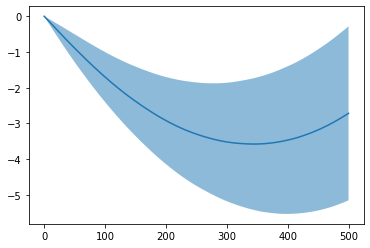

In [22]:
plt.fill_between(jnp.arange(sequence_length), cum_log_weight_mean + cum_log_weight_var, cum_log_weight_mean - cum_log_weight_var, alpha=0.5)
plt.plot(jnp.arange(sequence_length), cum_log_weight_mean)

Text(0, 0.5, 'g_rep(forward_potential_parameters)')

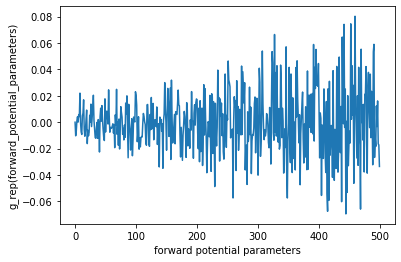

In [23]:
plt.plot(og[0])
plt.xlabel(f"forward potential parameters")
plt.ylabel(f"g_rep(forward_potential_parameters)")

that is really noisy.

### Away from AIS
as in the previous `Away from AIS` experiment, I am going to conduct SIS where the backward kernels and potentials linearly interpolate, but the sequence of forward kernels will be a RELU. I hypothesize that the g_rep for the forward parameters will be biased in the direction of a linear interpolation (i.e. identical to the backward kernel sequence).

In [24]:
run_key = random.PRNGKey(20)
dimension=1
num_particles = 1000
sequence_length=500
_, (mu, cov), dG = get_default_potential_initializer(dimension)
potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis]
#forward_potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis]
forward_potential_parameters = jnp.array([Relu(i,0.5) for i in jnp.linspace(0,1,sequence_length)])[..., jnp.newaxis]
backward_potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis][1:]
forward_dts=1e-2*jnp.ones(sequence_length)
backward_dts = 1e-2*jnp.ones(sequence_length)[1:]
g_subopt, subopt_weight_matrix, subopt_trajectories = ULA_vSMC_iteration(num_particles=num_particles,
                       potential = potential,
                       potential_parameters = potential_parameters,
                       forward_potential = potential, 
                       forward_potential_parameters = forward_potential_parameters,
                       forward_dts = forward_dts,
                       backward_potential = potential, 
                       backward_potential_parameters = backward_potential_parameters, 
                       backward_dts = backward_dts,
                       starter_key = run_key,
                       mu = mu,
                       cov = cov)

subopt_log_weight_matrix = ULA_SIS_log_weights_calculator(subopt_trajectories, forward_potential_parameters, backward_potential_parameters, potential_parameters, potential, 1e-2)
# compute the accumulation of variance of the weights
subopt_cum_log_weights = jnp.cumsum(subopt_log_weight_matrix, 0)
subopt_cum_log_weight_mean = subopt_cum_log_weights.mean(1)
subopt_cum_log_weight_var = subopt_cum_log_weights.std(1)

print(mod_log_partition_ratio(subopt_weight_matrix))
print(logsumexp(subopt_log_weight_matrix.sum(0)) - jnp.log(num_particles))

-0.7911401
-0.79114056


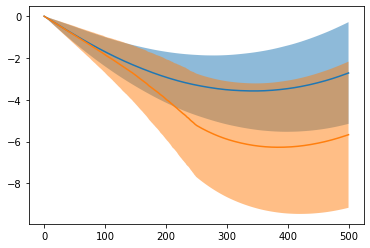

In [25]:
plt.fill_between(jnp.arange(sequence_length), cum_log_weight_mean + cum_log_weight_var, cum_log_weight_mean - cum_log_weight_var, alpha=0.5)
plt.plot(jnp.arange(sequence_length), cum_log_weight_mean)

plt.fill_between(jnp.arange(sequence_length), subopt_cum_log_weight_mean + subopt_cum_log_weight_var, subopt_cum_log_weight_mean - subopt_cum_log_weight_var, alpha=0.5)
plt.plot(jnp.arange(sequence_length), subopt_cum_log_weight_mean)

as we would expect, the far-from-AIS SISampler performs much worse. Let's look at the g_rep for comparison.

Text(0.5, 1.0, '$g_{rep}$')

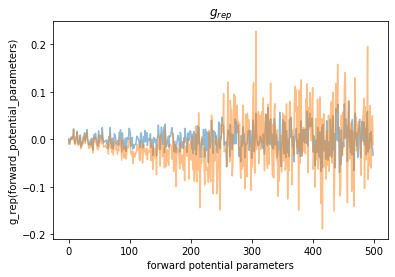

In [26]:
plt.plot(og[0], alpha=0.5)
plt.plot(g_subopt[0], alpha=0.5)
plt.xlabel(f"forward potential parameters")
plt.ylabel(f"g_rep(forward_potential_parameters)")
plt.title("$g_{rep}$")



**Observation**: it is obvious that there is a negative trend in the 'far-from-AIS' experiment through the first half of the parameterized kernel sequence. 

I guess it's worth remarking that these gradients are _very_ noisy. If indeed, there are no bugs that are causing this signal (and there is good reason, given the tests, to believe that there aren't any bugs), then here are some thoughts on what might be reasons for this noise.
1. we are not resampling...this is just SIS. Maybe we should be resampling
2. the family of parameterizable forward kernels is _very limited_. In fact, I am using the _same_ family of forward/backward kernels. Maybe we should define a more flexible family of forward kernels.
3. I am not sure if i should be backpropagating through _all_ of the parameters every time i compute the gradient of the forward kernels w.r.t. variational parameters.
4. vSMC specifies the need for control variates to minimize the variance. I am not too familiar with this, so 

In [48]:
run_key = random.PRNGKey(20)
dimension=1
num_particles = 1000
sequence_length=100
_, (mu, cov), dG = get_default_potential_initializer(dimension)
potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis]
fwd_potential_parameters = jnp.stack((jnp.linspace(0,1,sequence_length), jnp.zeros(sequence_length), jnp.zeros(sequence_length)),1)
backward_potential_parameters = jnp.linspace(0,1,sequence_length)[..., jnp.newaxis][1:]
forward_dts=1e-2*jnp.ones(sequence_length)
backward_dts = 1e-2*jnp.ones(sequence_length)[1:]
og, weight_matrix, trajectories = ULA_vSMC_iteration(num_particles=num_particles,
                       potential = potential,
                       potential_parameters = potential_parameters,
                       forward_potential = v1_forward_potential, 
                       forward_potential_parameters = fwd_potential_parameters,
                       forward_dts = forward_dts,
                       backward_potential = potential, 
                       backward_potential_parameters = backward_potential_parameters, 
                       backward_dts = backward_dts,
                       starter_key = run_key,
                       mu = mu,
                       cov = cov)

#log_weight_matrix = ULA_SIS_log_weights_calculator(trajectories, forward_potential_parameters, backward_potential_parameters, potential_parameters, potential, 1e-2)
# compute the accumulation of variance of the weights
cum_log_weights = jnp.cumsum(log_weight_matrix, 0)
cum_log_weight_mean = cum_log_weights.mean(1)
cum_log_weight_var = cum_log_weights.std(1)

print(mod_log_partition_ratio(weight_matrix))
#print(logsumexp(log_weight_matrix.sum(0)) - jnp.log(num_particles))


-1.6666813


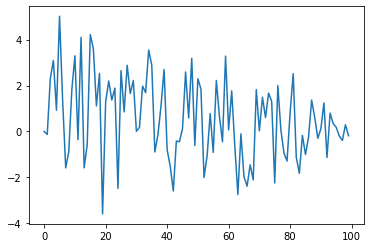

In [53]:
plt.plot(og[0][:,2])

In [36]:
jnp.stack((jnp.linspace(0,1,10), jnp.zeros(10), jnp.zeros(10)),1)[...,jnp.newaxis]

DeviceArray([[[0.        ],
              [0.        ],
              [0.        ]],

             [[0.11111111],
              [0.        ],
              [0.        ]],

             [[0.22222222],
              [0.        ],
              [0.        ]],

             [[0.33333334],
              [0.        ],
              [0.        ]],

             [[0.44444445],
              [0.        ],
              [0.        ]],

             [[0.5555556 ],
              [0.        ],
              [0.        ]],

             [[0.6666667 ],
              [0.        ],
              [0.        ]],

             [[0.7777778 ],
              [0.        ],
              [0.        ]],

             [[0.8888889 ],
              [0.        ],
              [0.        ]],

             [[1.        ],
              [0.        ],
              [0.        ]]], dtype=float32)